# **Laboratorio 11 - Proyecto de Consultoría - SparkML**


- Mónica Salvatierra 22249
- Derek Arreaga 22537

Link del repositorio: https://github.com/alee2602/LAB11-DS

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, stddev, min as min_, max as max_
from pyspark.sql.functions import sum as _sum, when
import seaborn as sns
import matplotlib.pyplot as plt

### **Iniciar sesión en Spark**

In [ ]:
spark = (
    SparkSession.builder
    .appName("Churn-LogReg")
    .getOrCreate()
)

spark

### **Carga de datos**

In [ ]:
path_hist = "abandono_clientes.csv"   # histórico CON columna 'Churn'
path_new  = "clientes_nuevos.csv"     # futuros SIN 'Churn'

df_hist = spark.read.csv(path_hist, header=True, inferSchema=True)
df_new  = spark.read.csv(path_new,  header=True, inferSchema=True)

print("Histórico (con etiqueta):", df_hist.count(), "filas")
print("Nuevos (sin etiqueta):",   df_new.count(),  "filas")

df_hist.printSchema()
df_hist.show(5, truncate=False)

Histórico (con etiqueta): 900 filas
Nuevos (sin etiqueta): 6 filas
root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Names           |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                          |Company                    |Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+--------------------------

### **Observar la existencia de valores nulos y balanceo entre clases**

In [12]:

# Nulos por columna
nulls = df_hist.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_hist.columns])
nulls.show(truncate=False)

# Balance de clases
if "Churn" in df_hist.columns:
    df_hist.groupBy("Churn").count().show()

+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date|Location|Company|Churn|
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|0    |0  |0             |0              |0    |0        |0           |0       |0      |0    |
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



No existen valores nulos en los datos históricos. Sin embargo, las clases se encuentran desbalanceadas. Se podría utilizar la técnica de SMOTE al momento de realizar el modelo.

### **Resumen estadístico de las variables numéricas**

In [13]:

numeric_cols = [c for c, t in df_hist.dtypes if t in ("double", "int") and c != "Churn"]

stats = df_hist.select(
    *[min_(col(c)).alias(f"{c}_min") for c in numeric_cols],
    *[max_(col(c)).alias(f"{c}_max") for c in numeric_cols],
    *[avg(col(c)).alias(f"{c}_mean") for c in numeric_cols],
    *[stddev(col(c)).alias(f"{c}_std") for c in numeric_cols]
)
stats.show(truncate=False)

+-------+------------------+-------------------+---------+-------------+-------+------------------+-------------------+---------+-------------+-----------------+-------------------+--------------------+----------------+-----------------+-----------------+------------------+-------------------+-----------------+------------------+
|Age_min|Total_Purchase_min|Account_Manager_min|Years_min|Num_Sites_min|Age_max|Total_Purchase_max|Account_Manager_max|Years_max|Num_Sites_max|Age_mean         |Total_Purchase_mean|Account_Manager_mean|Years_mean      |Num_Sites_mean   |Age_std          |Total_Purchase_std|Account_Manager_std|Years_std        |Num_Sites_std     |
+-------+------------------+-------------------+---------+-------------+-------+------------------+-------------------+---------+-------------+-----------------+-------------------+--------------------+----------------+-----------------+-----------------+------------------+-------------------+-----------------+------------------+
|22.

### **Distribución de las variables numéricas**

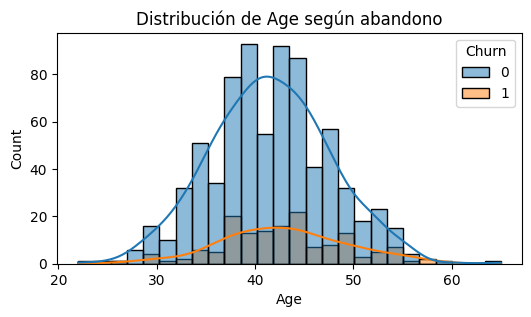

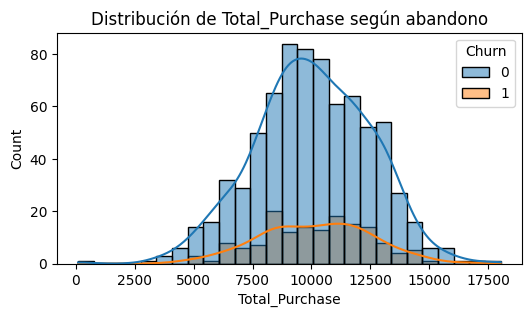

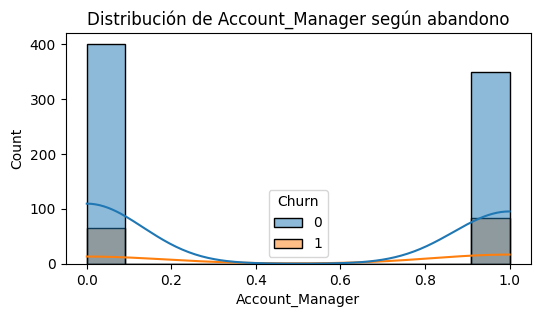

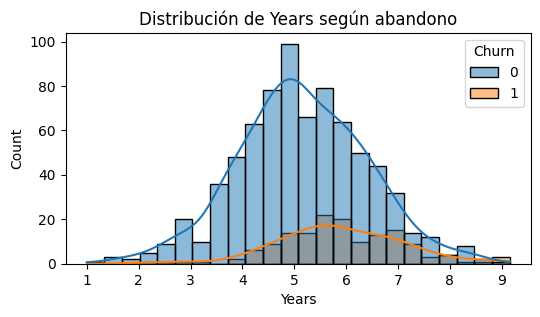

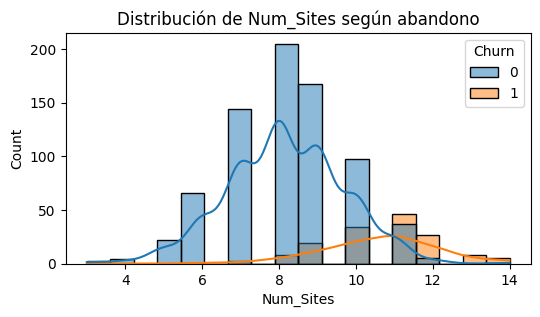

In [14]:

pdf = df_hist.toPandas()

for col_name in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=pdf, x=col_name, hue="Churn", kde=True)
    plt.title(f"Distribución de {col_name} según abandono")
    plt.show()


### **Matriz de correlación**

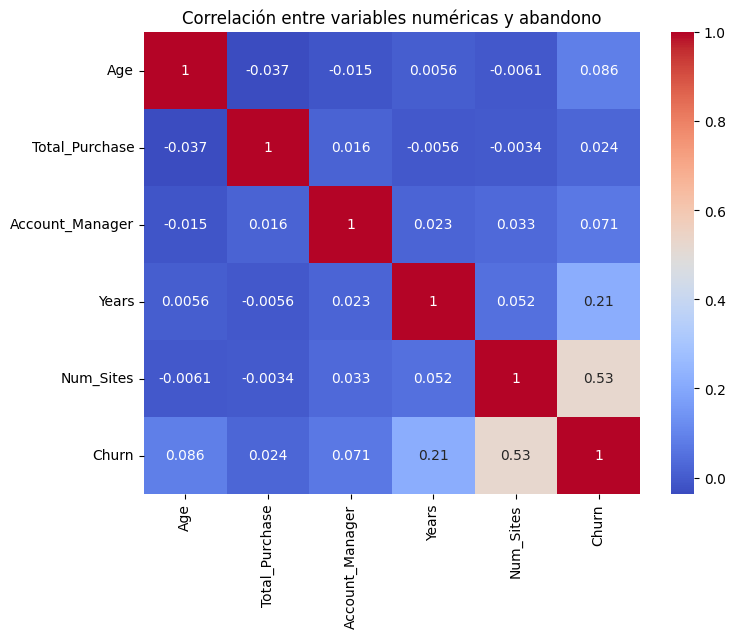

Churn              1.000000
Num_Sites          0.525398
Years              0.214329
Age                0.085926
Account_Manager    0.070611
Total_Purchase     0.024031
Name: Churn, dtype: float64


In [15]:

corr = pdf[numeric_cols + ["Churn"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Correlación entre variables numéricas y abandono")
plt.show()

print(corr["Churn"].sort_values(ascending=False))


### **División de datos y pipeline del modelo**

**Seleccionar columnas relevantes**

In [16]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col

In [17]:
features = ["Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"]

assembler = VectorAssembler(inputCols=features, outputCol="features_vector")


**Normalizar las variables**

In [18]:
scaler = StandardScaler(inputCol="features_vector", outputCol="features_scaled")

df_hist_clean = df_hist.select(*(features + ["Churn"]))

**División de datos**

In [19]:
train_df, test_df = df_hist_clean.randomSplit([0.8, 0.2], seed=42)
print("Entrenamiento:", train_df.count(), "Prueba:", test_df.count())

Entrenamiento: 754 Prueba: 146


### **Definición de modelos**

#### Regresión Logística

In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

lr = LogisticRegression(featuresCol="features_scaled", labelCol="Churn")

pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

lr_model = pipeline_lr.fit(train_df)

lr_preds = lr_model.transform(test_df)


In [21]:
evaluator_auc = BinaryClassificationEvaluator(labelCol="Churn", metricName="areaUnderROC")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="Churn", metricName="f1")

auc_lr = evaluator_auc.evaluate(lr_preds)
f1_lr  = evaluator_f1.evaluate(lr_preds)

print(f"AUC (LogReg): {auc_lr:.3f}")
print(f"F1-Score (LogReg): {f1_lr:.3f}")


AUC (LogReg): 0.937
F1-Score (LogReg): 0.890


#### Random Forest

In [22]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features_scaled", labelCol="Churn", numTrees=100, maxDepth=5, seed=42)

pipeline_rf = Pipeline(stages=[assembler, scaler, rf])
rf_model = pipeline_rf.fit(train_df)
rf_preds = rf_model.transform(test_df)

In [23]:
auc_rf = evaluator_auc.evaluate(rf_preds)
f1_rf  = evaluator_f1.evaluate(rf_preds)

print(f"AUC (Random Forest): {auc_rf:.3f}")
print(f"F1-Score (Random Forest): {f1_rf:.3f}")

AUC (Random Forest): 0.919
F1-Score (Random Forest): 0.855


#### **Comparación de Modelos**

Matriz de confusión

In [33]:
from pyspark.sql import functions as F

def show_conf_matrix(preds, model_name):
  conf_matrix = (
      preds.groupBy("Churn", "prediction")
      .count()
      .orderBy("Churn", "prediction")
      .toPandas()
  )

  conf_matrix_pivot = conf_matrix.pivot(index="Churn", columns="prediction", values="count").fillna(0)
  conf_matrix_pivot.columns = ["Pred_No_Churn", "Pred_Churn"]
  conf_matrix_pivot.index = ["Real_No_Churn", "Real_Churn"]
  print(conf_matrix_pivot)

  plt.figure(figsize=(5,4))
  sns.heatmap(conf_matrix_pivot, annot=True, fmt=".0f", cmap="Blues")
  plt.title(f"Matriz de Confusión - {model_name}")
  plt.ylabel("Valor Real")
  plt.xlabel("Predicción del Modelo")
  plt.show()


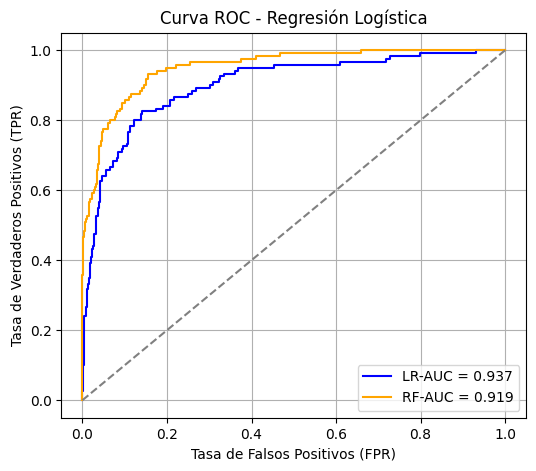

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

roc = lr_model.stages[-1].summary.roc.toPandas()
roc_rf = rf_model.stages[-1].summary.roc.toPandas()

plt.figure(figsize=(6, 5))
plt.plot(roc['FPR'], roc['TPR'], color='blue', label=f"LR-AUC = {auc_lr:.3f}")
plt.plot(roc_rf['FPR'], roc_rf['TPR'], color='orange', label=f"RF-AUC = {auc_rf:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Curva ROC - Regresión Logística")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Ambos modelos presentan una excelente capacidad para discriminar entre clientes que abandonan y los que no, con valores de `AUC` superiores a **0.9**.
Sin embargo, la `Regresión Logística` supera ligeramente al `Random Forest`, lo que indica que logra una mejor separación de las clases en términos de probabilidad.
Esto sugiere que las relaciones entre las variables y la probabilidad de abandono son predominantemente lineales, por lo que un modelo más complejo no aporta gran mejora.

In [24]:
print("===== COMPARACIÓN DE MODELOS =====")
print(f"Logistic Regression -> AUC: {auc_lr:.3f}, F1: {f1_lr:.3f}")
print(f"Random Forest       -> AUC: {auc_rf:.3f}, F1: {f1_rf:.3f}")

===== COMPARACIÓN DE MODELOS =====
Logistic Regression -> AUC: 0.937, F1: 0.890
Random Forest       -> AUC: 0.919, F1: 0.855


El **F1** combina *precisión* y *recall*, y en este caso la `Regresión Logística` logra un mejor equilibrio, identificando más clientes que efectivamente abandonan, es decir menos falsos negativos, sin aumentar demasiado los falsos positivos.
Aunque el `Random Forest` también tiene un desempeño alto, su **F1** ligeramente menor sugiere que comete más errores al predecir casos de abandono reales.

               Pred_No_Churn  Pred_Churn
Real_No_Churn            113           3
Real_Churn                12          18


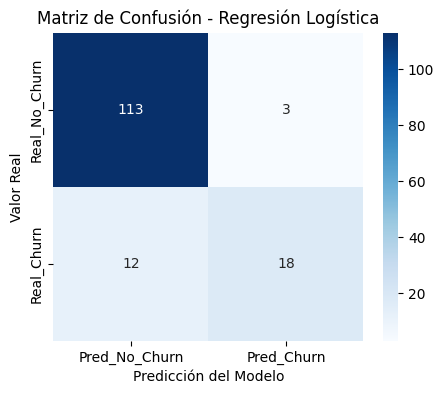

In [34]:
show_conf_matrix(lr_preds, "Regresión Logística")

               Pred_No_Churn  Pred_Churn
Real_No_Churn            113           3
Real_Churn                16          14


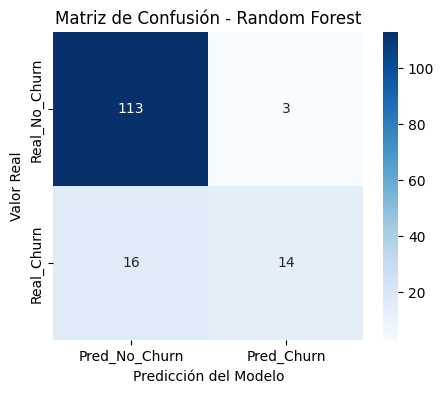

In [35]:
show_conf_matrix(rf_preds, "Random Forest")

En ambos modelos, la clasificación de los clientes que no abandonan (**Clase 0**) es muy buena ya que solo hay tres falsos positivos.

La diferencia se observa en la detección de clientes que sí abandonan (**Clase 1**):

- La `Regresión Logística` identifica correctamente **18** de **30** casos.

- El `Random Forest` solo detecta **14** de **30**

Esto significa que la `regresión logística` pierde menos clientes reales al momento de la predicción, algo clave en estrategias de retención.

En contextos donde el costo de perder un cliente es alto, es preferible maximizar el recall, incluso a costa de algunos falsos positivos. Es por eso que seleccionamos como modelo final al de `regresión logística`.

#### **Utilizar el modelo de `Regresión Logística` en clientes nuevos**

In [40]:
df_new_selected = df_new.select(*(features + ["Names", "Company"]))
lr_preds_new = lr_model.transform(df_new_selected)

lr_preds_new.select("Names", "Company", "probability", "prediction").show(truncate=False)


+--------------+----------------+------------------------------------------+----------+
|Names         |Company         |probability                               |prediction|
+--------------+----------------+------------------------------------------+----------+
|Andrew Mccall |King Ltd        |[0.9026961450628217,0.0973038549371783]   |0.0       |
|Michele Wright|Cannon-Benson   |[0.0033522356103662444,0.9966477643896338]|1.0       |
|Jeremy Chang  |Barron-Robertson|[0.033669707745203135,0.9663302922547968] |1.0       |
|Megan Ferguson|Sexton-Golden   |[0.009573720513880328,0.9904262794861197] |1.0       |
|Taylor Young  |Wood LLC        |[0.7540278631337725,0.24597213686622754]  |0.0       |
|Jessica Drake |Parks-Robbins   |[0.20247971813700893,0.7975202818629911]  |1.0       |
+--------------+----------------+------------------------------------------+----------+



Los resultados muestran que el modelo identifica con alta confianza a **Michele Wright**, **Jeremy Chang**, **Megan Ferguson** y **Jessica Drake** como clientes con alta probabilidad de `abandonar`. En contraste, **Andrew Mccall** y **Taylor Young** presentan una probabilidad significativamente menor de churn, por lo que se consideran clientes `estables`.

### **Interpretación y conclusiones**

El modelo de Regresión Logística permite no solo clasificar a los clientes, sino también interpretar las probabilidades de abandono de manera transparente, lo que facilita la toma de decisiones estratégicas. En este caso, los resultados sugieren que la empresa debería enfocar esfuerzos de retención en los cuatro clientes identificados con probabilidad alta de churn, implementando estrategias como descuentos personalizados, mejora de soporte o seguimiento proactivo.

En conclusión, la Regresión Logística demostró un equilibrio óptimo entre rendimiento y explicabilidad, siendo una herramienta útil para la detección temprana de posibles bajas en la base de clientes y para la optimización de estrategias de fidelización.